In [1]:
import numpy as np
from skimage import io
from scipy.stats import norm

import matplotlib.pyplot as plt

# Bayes' and kNN classifier from scratch

## Design a Bayes’ classifier from scratch! 

1. Get images of forest and urban landscapes (if needed hand-craft the areas so that it only has pixels of one type).

In [10]:
image_path = {
    "urban": "bytom/bytom_B04.tiff",
    "forest": "tatry/tatry_B04.tiff"
}
test_image_path = "opole.tiff"

2. Plot their respective histograms and find parametric models for their PDFs → find these parameters

Loading images and flattening pixel values

In [11]:
images = {k: io.imread(v).flatten() for k, v in image_path.items()}

Plotting histograms and fitting Gaussian distributions

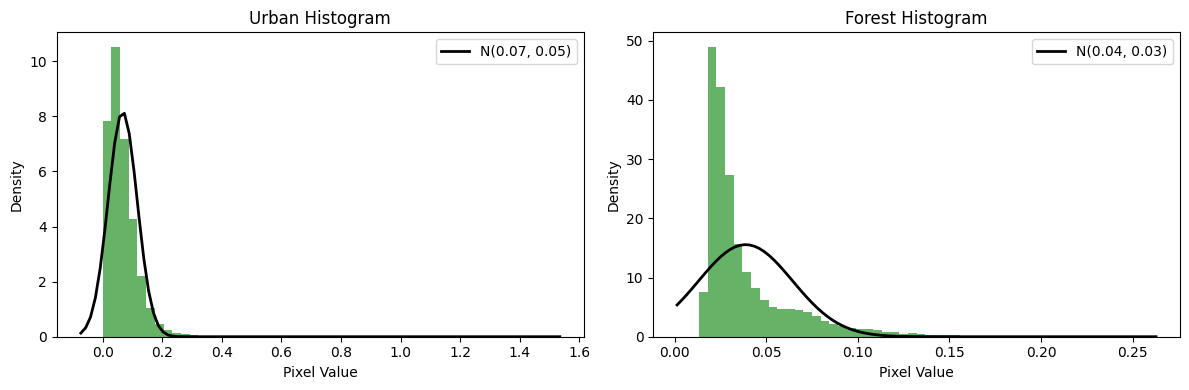

Fitted parameters for each image:
urban: mean=0.07, std=0.05
forest: mean=0.04, std=0.03


In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
params = {}

for ax, (label, pixels) in zip(axes, images.items()):
    # Plot histogram
    ax.hist(pixels, bins=50, density=True, alpha=0.6, color='g')
    ax.set_title(f"{label.capitalize()} Histogram")
    ax.set_xlabel("Pixel Value")
    ax.set_ylabel("Density")
    
    # Fit Gaussian (Normal) distribution
    mu, std = norm.fit(pixels)
    params[label] = {'mean': mu, 'std': std}
    
    # Plot PDF
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'k', linewidth=2, label=f'N({mu:.2f}, {std:.2f})')
    ax.legend()

plt.tight_layout()
plt.show()

print("Fitted parameters for each image:")
for label, param in params.items():
    print(f"{label}: mean={param['mean']:.2f}, std={param['std']:.2f}")

Creating a function for classifying

In [ ]:
def classify_image(image, params):
    # Flatten image for classification
    pixels = image.flatten()
    # Get parameters for each class
    mu_urban, std_urban = params['urban']['mean'], params['urban']['std']
    mu_forest, std_forest = params['forest']['mean'], params['forest']['std']
    # Compute likelihoods
    p_urban = norm.pdf(pixels, mu_urban, std_urban)
    p_forest = norm.pdf(pixels, mu_forest, std_forest)
    # Classify: 0 for urban (red), 1 for forest (blue)
    labels = np.where(p_forest > p_urban, 1, 0)
    # Create RGB image: urban=red, forest=blue
    classified_img = np.zeros((pixels.shape[0], 3), dtype=np.uint8)
    classified_img[labels == 0] = [255, 0, 0]   # Red for urban
    classified_img[labels == 1] = [0, 0, 255]   # Blue for forest
    # Reshape to original image shape
    classified_img = classified_img.reshape((*image.shape, 3))
    return classified_img



Classifying image of the Opole city and visualizing both before and after classification

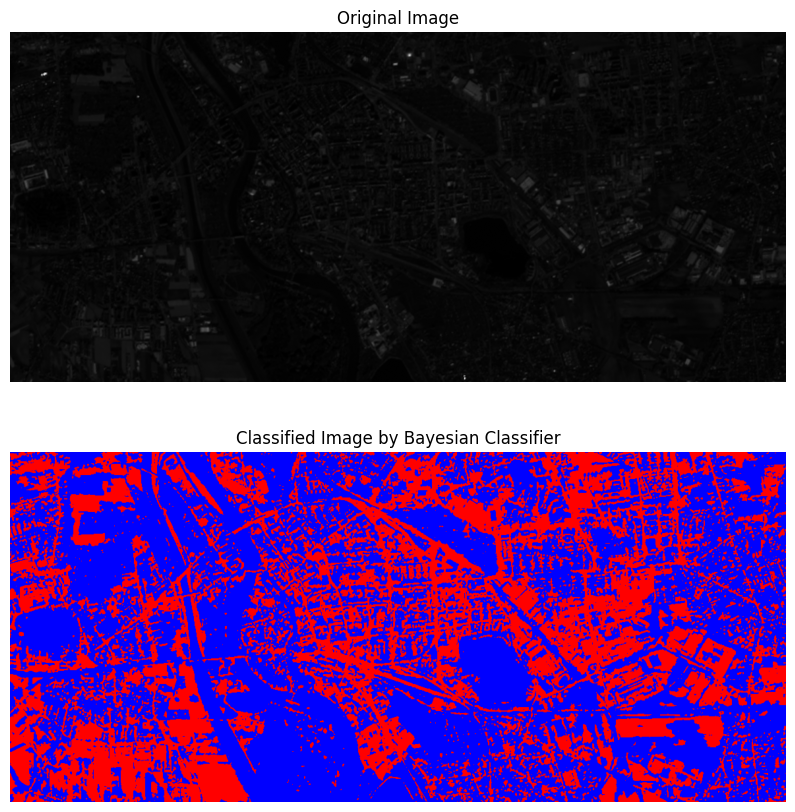

In [23]:
new_image = io.imread(test_image_path)
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.imshow(new_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

result = classify_image(new_image, params)
plt.subplot(2,1,2)
plt.imshow(result)
plt.title('Classified Image by Bayesian Classifier')
plt.axis('off')
plt.show()

**Results**

The Bayes' Classification works very well on the following example of the Opole city. Each area covered by buildings and roads were classified correctly as an urban area. Other pixels which are not classified as urban, are classified as forest. It doesn't mean that is a forest, because on the chosen scene there is no forests, but parks, some small crops, or a rivers (in our case Odra river in the center).

## Design a kNN classifier from scratch

1. Use the same problem as the previous question (i.e. forest-urban classification)

In [24]:
image_path = {
    "urban": "bytom/bytom_B04.tiff",
    "forest": "tatry/tatry_B04.tiff"
}
test_image_path = "opole.tiff"

2. Design a k-NN classifier now; write all steps clearly

Preparing training data. Extracting pixel values from urban and forest images, then labeling them accordingly.

In [ ]:
urban_pixels = io.imread(image_path['urban']).flatten()
forest_pixels = io.imread(image_path['forest']).flatten()
X_train = np.concatenate([urban_pixels, forest_pixels])
y_train = np.concatenate([np.zeros_like(urban_pixels), np.ones_like(forest_pixels)])


Defining the k-NN classification function

In [ ]:
# We need to use KDTree, normal k-NN would be too slow
from scipy.spatial import KDTree
def knn_classify_fast(pixels, X_train, y_train, k=5):
    tree = KDTree(X_train.reshape(-1,1))
    dists, idxs = tree.query(pixels.reshape(-1,1), k=k)
    knn_labels = y_train[idxs]
    if k == 1:
        labels = knn_labels
    else:
        labels = np.round(np.mean(knn_labels, axis=1))
    return labels

Applying the classifier to a new image

In [41]:
# Apply fast k-NN classifier to new image and visualize
new_image = io.imread(test_image_path)
pixels = new_image.flatten()
knn_labels = knn_classify_fast(pixels, X_train, y_train, k=2)
knn_img = np.zeros((pixels.shape[0], 3), dtype=np.uint8)
knn_img[knn_labels == 0] = [255, 0, 0]   # Red for urban
knn_img[knn_labels == 1] = [0, 0, 255]   # Blue for forest
knn_img = knn_img.reshape((*new_image.shape, 3))


Present the result

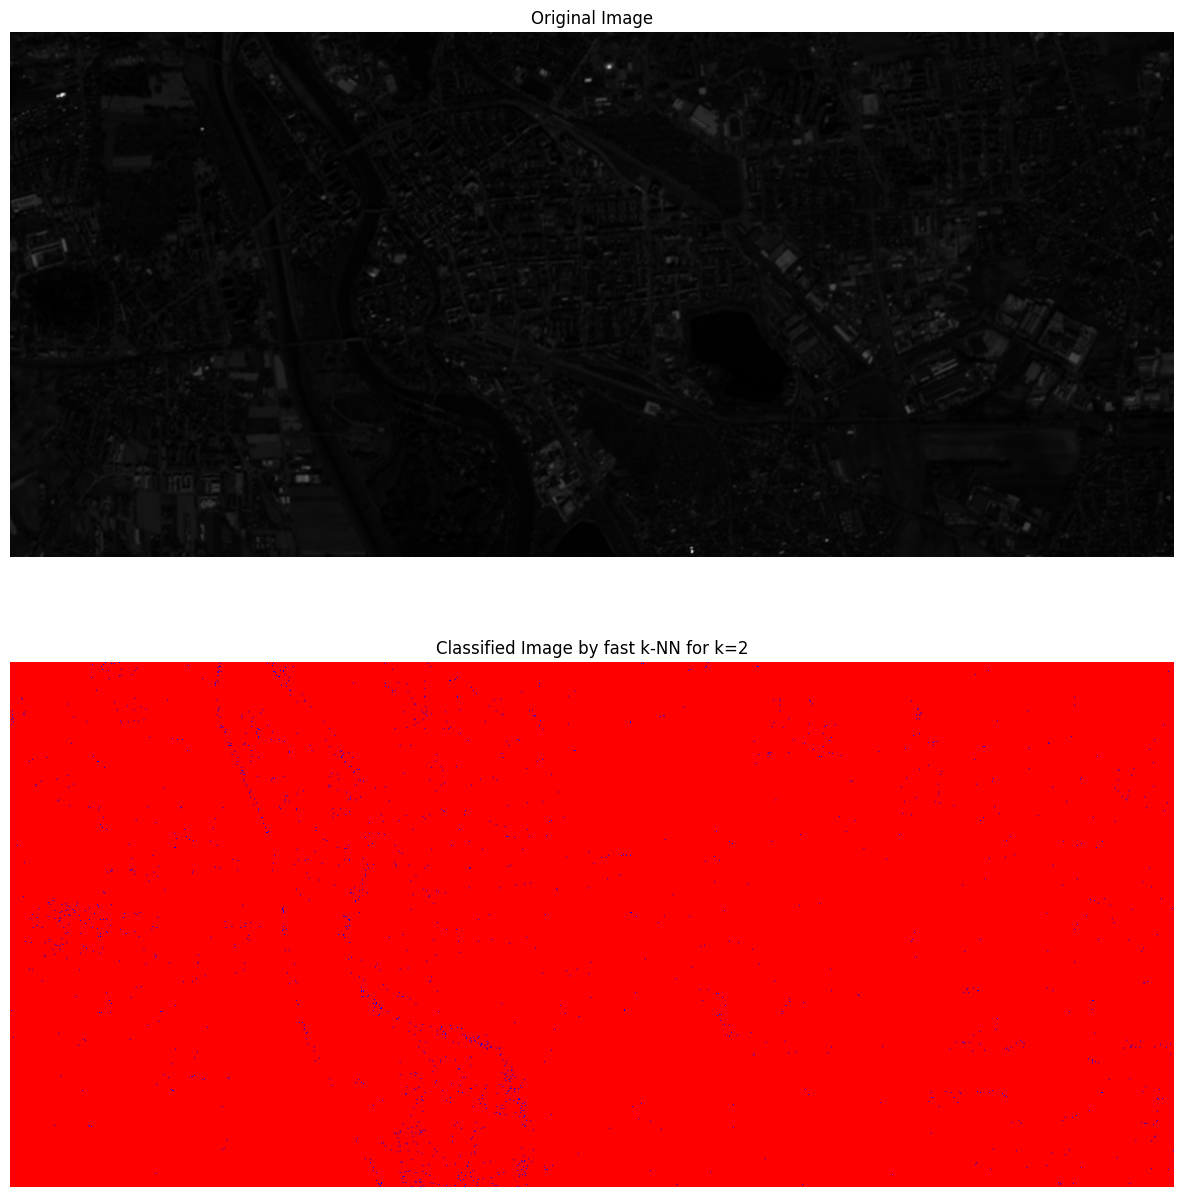

In [44]:
plt.figure(figsize=(40,15))
plt.subplot(2,1,1)
plt.imshow(new_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(2,1,2)
plt.imshow(knn_img)
plt.title('Classified Image by fast k-NN for k=2')
plt.axis('off')
plt.show()

**Results**

Results are much worser than in Bayes' classifier. Almost everything has been classified as an urban area. In random places pixels labeled as forest are present. However, the biggest forest pixels concentration is along the border of the Odra river, which is classified correctly (because it is not urban area).

4. Change k to 1 to 3 to 5 and comment on the differences you observe

For k=1:

In [45]:
pixels = new_image.flatten()
knn_labels_1 = knn_classify_fast(pixels, X_train, y_train, k=1)
knn_img = np.zeros((pixels.shape[0], 3), dtype=np.uint8)
knn_img[knn_labels_1 == 0] = [255, 0, 0]   # Red for urban
knn_img[knn_labels_1 == 1] = [0, 0, 255]   # Blue for forest
knn_img_1 = knn_img.reshape((*new_image.shape, 3))

For k=3:

In [46]:
pixels = new_image.flatten()
knn_labels_3 = knn_classify_fast(pixels, X_train, y_train, k=3)
knn_img = np.zeros((pixels.shape[0], 3), dtype=np.uint8)
knn_img[knn_labels_3 == 0] = [255, 0, 0]   # Red for urban
knn_img[knn_labels_3 == 1] = [0, 0, 255]   # Blue for forest
knn_img_3 = knn_img.reshape((*new_image.shape, 3))

For k=5:

In [47]:
pixels = new_image.flatten()
knn_labels_5 = knn_classify_fast(pixels, X_train, y_train, k=5)
knn_img = np.zeros((pixels.shape[0], 3), dtype=np.uint8)
knn_img[knn_labels_5 == 0] = [255, 0, 0]   # Red for urban
knn_img[knn_labels_5 == 1] = [0, 0, 255]   # Blue for forest
knn_img_5 = knn_img.reshape((*new_image.shape, 3))

Visualizing results

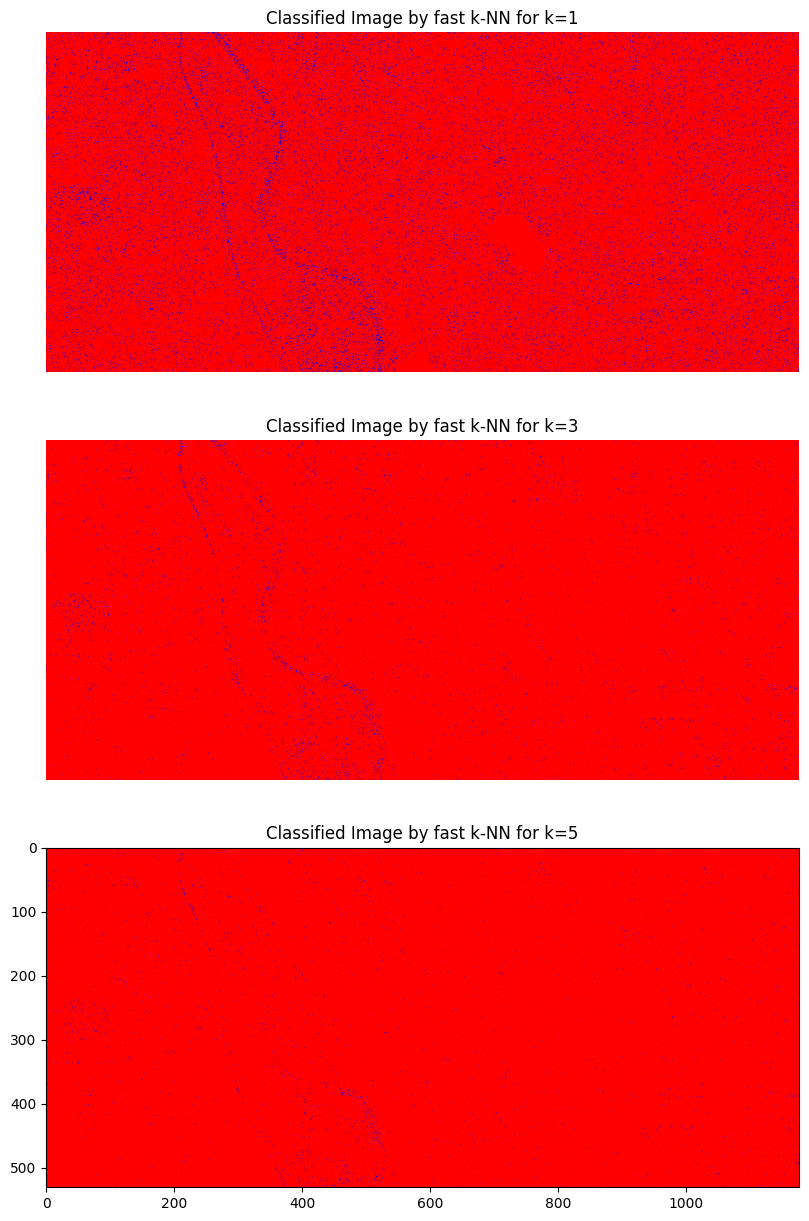

In [48]:
plt.figure(figsize=(40,15))
plt.subplot(3,1,1)
plt.imshow(knn_img_1)
plt.title('Classified Image by fast k-NN for k=1')
plt.axis('off')
plt.subplot(3,1,2)
plt.imshow(knn_img_3)
plt.title('Classified Image by fast k-NN for k=3')
plt.axis('off')
plt.subplot(3,1,3)
plt.imshow(knn_img_5)
plt.title('Classified Image by fast k-NN for k=5')
plt.show()

**Results**

The smaller number of neighbours we take, then more pixels are likely to be classified as forest (non-urban) areas. For `k=1` forest areas seem to be randomly placed. In fact, borders of the Odra river are outlined well as forest. For higher `k` values less pixels are classified as a forest. Vast pixels are considered to be urban. 

In our case of the red band of Opole city, Bayes' classification works better than k-NN.